# **Project: Time Series - Forecasting Stock Prices**
# Marks: 30

Welcome to the project on Time Series. We will use the Amazon Stock Prices dataset for this project.
 
----------------
## **Context:** 
----------------

**Stocks are one of the most popular financial instruments invented for building wealth** and are the **centerpiece of any investment portfolio.** Recent advances in trading technology have opened up stock markets in such a way that nowadays, **nearly anybody can own stock.** 

In the last few decades, there's been an **explosive increase in the average person's interest for the stock market.** This makes stock value prediction an interesting and popular problem to explore.


------------------
## **Objective:**
------------------

Amazon.com, Inc. engages in the retail sale of consumer products and subscriptions in North America as well as internationally. This dataset consists of monthly average stock closing prices of Amazon over a period of 12 years from 2006 to 2017. We have to **build a time series model** using the AR, MA, ARMA and ARIMA models in order to **forecast the stock closing price of Amazon.**

--------------------------
## **Data Dictionary:**
--------------------------
- **date:** Date when the price was collected
- **close:** Closing price of the stock

### Importing libraries

In [1]:
# Install this to upgrade the statsmodels package. It will be required to use AR, MA, & ARMA models
#!pip install statsmodels --upgrade

In [2]:
#If the above command doesn't work, please run the below command in the anaconda prompt, otherwise ignore
#conda install statsmodels

In [3]:
# Importing libraries for data manipulation
import pandas as pd
import numpy as np

#Importing libraries for visualization
import matplotlib.pylab as plt
import seaborn as sns

#Importing library for date manipulation
from datetime import datetime

#To calculate the MSE or RMSE
from sklearn.metrics import mean_squared_error

#Importing acf and pacf functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Importing models from statsmodels library
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

#To ignore the warnings
import warnings
warnings.filterwarnings('ignore')

### Reading the dataset

In [4]:
#If you are having an issue while loading the excel file in pandas, please run the below command in anaconda prompt, otherwise ignore.
#conda install -c anaconda xlrd

In [5]:
df = pd.read_excel('amazon_stocks_prices.xlsx')
df.head()

,date,close
0,2006-01-01,45.22
1,2006-02-01,38.82
2,2006-03-01,36.38
3,2006-04-01,36.32
4,2006-05-01,34.13


### Checking info 

### **Question 1: Check the info of the dataset and write your observations. (2 Marks)**

In [6]:
#Write your code here
#info
print(df.info)
#description
print(df.describe().T)

<bound method DataFrame.info of           date    close
0   2006-01-01    45.22
1   2006-02-01    38.82
2   2006-03-01    36.38
3   2006-04-01    36.32
4   2006-05-01    34.13
..         ...      ...
139 2017-08-01   971.44
140 2017-09-01   968.99
141 2017-10-01  1000.72
142 2017-11-01  1139.81
143 2017-12-01  1168.84

[144 rows x 2 columns]>
       count        mean         std   min     25%      50%       75%      max
close  144.0  299.068889  280.564066  27.8  82.205  202.425  375.4275  1168.84


**Observations:**
- The data set tracks amazon stock prices from January 1st 2006 to December 1st 2017.
    - Month by Month tracking
- There has been a sharp increase in stock price, from 45.22 USD to over 1100 USD.
- The function clearly has memory, as there is a dependency on previous stock prices. However, we will eventually need to estimate it, because clearly very old values like the first price in row 0, do not really have relevance calculating new values.
- The growth accelerated sharply, going from 971 USD to 1168 USD in just 4 months. Almost 200 USD.
    - There is probably a growing trend to the data that we must analyze.
- The range is wide, as seen before. Going from a minimum of 27 USD to 1168. Since the minimum is below the start price, there was a dip in prices below row 0.
- The quarter percentiles increase drastically, with a great increase from 75th percentile to max.
    - As seen from the info, the prices started growing at a very accelerated pace at the end.

In [7]:
# Setting date as the index
df = df.set_index(['date'])
df.head()

,close
date,
2006-01-01,45.22
2006-02-01,38.82
2006-03-01,36.38
2006-04-01,36.32
2006-05-01,34.13


Now, let's **visualize the time series** to get an idea about the trend and/or seasonality within the data.

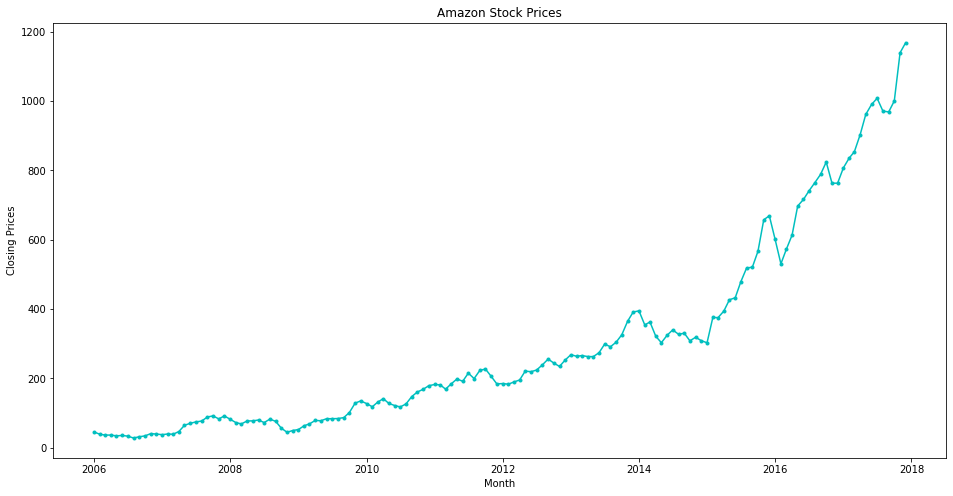

In [8]:
# Visualizing the time series
plt.figure(figsize=(16,8))
plt.xlabel("Month")
plt.ylabel("Closing Prices")
plt.title('Amazon Stock Prices')
plt.plot(df.index, df.close, color = 'c', marker='.')

**Observations:**
- We can see that the series has an **upward trend with some seasonality.** This implies that the **average stock price of Amazon has been increasing almost every year.**
- Before building different models, it is important to **check whether the series is stationary or not.**

Let us first split the dataset into train and test data

### Splitting the dataset

In [9]:
# Splitting the data into train and test
df_train = df.loc['2006-01-01':'2015-12-01']
df_test = df.loc['2016-01-01' : '2017-12-01']
print(df_train)
print(df_test)

             close
date              
2006-01-01   45.22
2006-02-01   38.82
2006-03-01   36.38
2006-04-01   36.32
2006-05-01   34.13
...            ...
2015-08-01  518.46
2015-09-01  520.96
2015-10-01  566.74
2015-11-01  657.70
2015-12-01  669.26

[120 rows x 1 columns]
              close
date               
2016-01-01   601.06
2016-02-01   530.62
2016-03-01   572.37
2016-04-01   613.59
2016-05-01   697.47
2016-06-01   716.39
2016-07-01   741.47
2016-08-01   764.84
2016-09-01   788.97
2016-10-01   824.44
2016-11-01   763.34
2016-12-01   763.33
2017-01-01   807.51
2017-02-01   835.75
2017-03-01   854.24
2017-04-01   903.39
2017-05-01   961.72
2017-06-01   990.44
2017-07-01  1008.48
2017-08-01   971.44
2017-09-01   968.99
2017-10-01  1000.72
2017-11-01  1139.81
2017-12-01  1168.84


Now let us check the **rolling mean and standard deviation** of the series to **visualize if the series has any trend or seasonality.**

### Testing the stationarity of the series

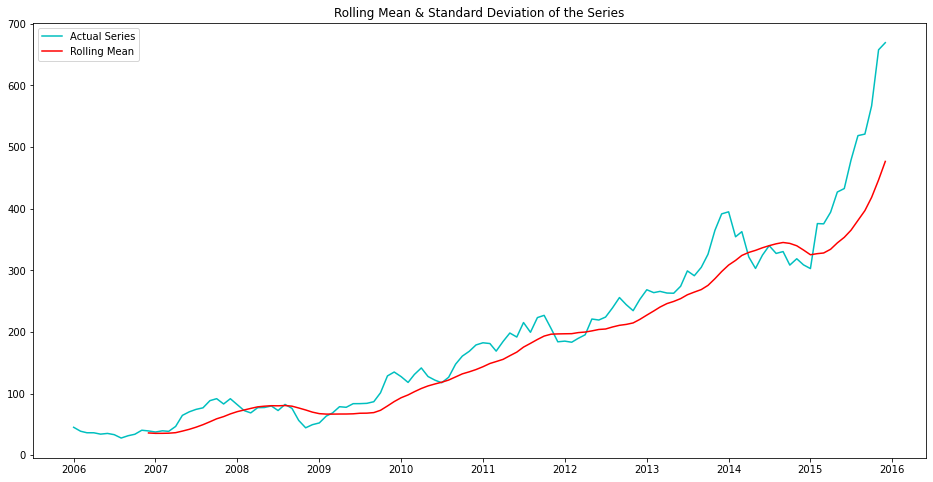

In [10]:
# Calculating the rolling mean and standard deviation for a window of 12 observations
rolmean=df_train.rolling(window=12).mean()
rolstd=df_train.rolling(window=12).std()

#Visualizing the rolling mean and standard deviation

plt.figure(figsize=(16,8))
actual = plt.plot(df_train, color='c', label='Actual Series')
rollingmean = plt.plot(rolmean, color='red', label='Rolling Mean') 
#rollingstd = plt.plot(rolstd, color='green', label='Rolling Std. Dev.')
plt.title('Rolling Mean & Standard Deviation of the Series')
plt.legend()
plt.show()

**Observations:**
- We can see there is an upward trend in the series.
- We can confirm that **the series is not stationary.**

We can also use the **Augmented Dickey-Fuller (ADF) Test** to verify if the series is stationary or not.
The null and alternate hypotheses for the ADF Test are defined as: 
- **Null hypothesis:** The Time Series is non-stationary
- **Alternative hypothesis:** The Time Series is stationary

In [11]:
#Define a function to use adfuller test
def adfuller(df_train):
  #Importing adfuller using statsmodels
  from statsmodels.tsa.stattools import adfuller
  print('Dickey-Fuller Test: ')
  adftest = adfuller(df_train['close'])
  adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Observations'])
  for key,value in adftest[4].items():
    adfoutput['Critical Value (%s)'%key] = value
  print(adfoutput)
adfuller(df_train)

Dickey-Fuller Test: 
Test Statistic            3.464016
p-value                   1.000000
Lags Used                 0.000000
No. of Observations     119.000000
Critical Value (1%)      -3.486535
Critical Value (5%)      -2.886151
Critical Value (10%)     -2.579896
dtype: float64


**Observations:**
1. From the above test, we can see that the **p-value = 1 i.e. > 0.05** (For 95% confidence intervals) therefore, **we fail to reject the null hypothesis.**
2. Hence, **we can confirm that the series is non-stationary.**

### Making the series stationary

We can use some of the following methods to convert a non-stationary series into a stationary one:
1. **Log Transformation**
2. **By differencing the series (lagged series)**

Let's first use a log transformation over this series to remove exponential variance and check the stationarity of the series again.

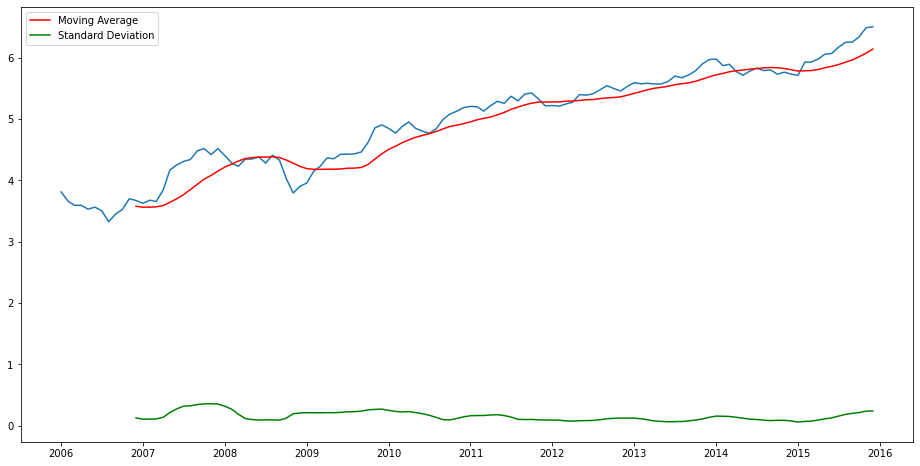

In [12]:
# Visualize the rolling mean and standard deviation after using log transformation
plt.figure(figsize=(16,8))
df_log = np.log(df_train)
MAvg = df_log.rolling(window=12).mean()
MStd = df_log.rolling(window=12).std()
plt.plot(df_log)
plt.plot(MAvg, color='r', label = 'Moving Average')
plt.plot(MStd, color='g', label = 'Standard Deviation')
plt.legend()
plt.show()

**Observations:**
- Since **we can still see the upward trend in the series**, we can conclude that **the series is still non-stationary.** 
- However, the standard deviation is almost constant which implies that **now the series has constant variance.**

**Let's shift the series by order 1 (or by 1 month) & apply differencing (using lagged series)** and then check the rolling mean and standard deviation.

### **Question 2: Visualize the rolling mean and rolling standard deviation of the shifted series (df_shift) and check the stationarity by calling the adfuller() function. Also, write your observations on the same. (3 Marks)**

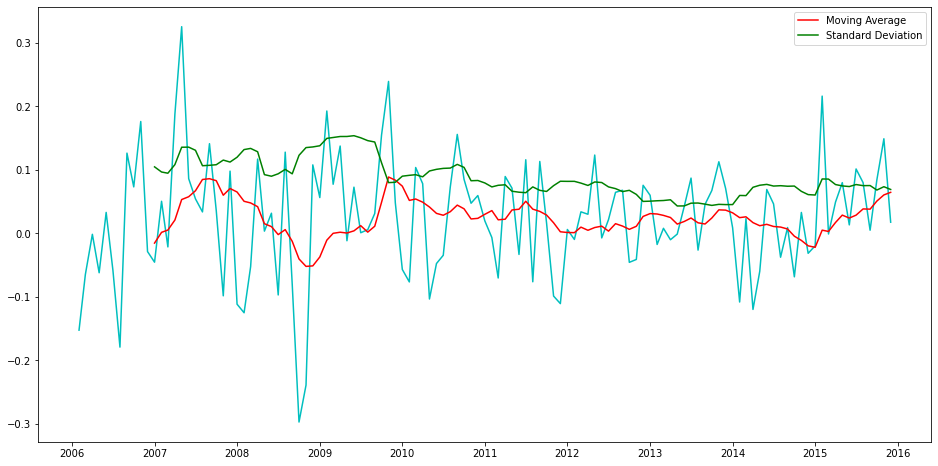

In [13]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 1)
MAvg_shift = df_shift.rolling(window=12).mean()
MStd_shift = df_shift.rolling(window=12).std()
plt.plot(df_shift, color='c')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

#Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

**Observations:**
- Despite looking noisy, both the moving average and standard deviation no longer have a trend.
    - We have to consider the value window, all the values are located in a very small range around 0.
    - Despite this apparent noise in the moving average and standard deviation, these are in fact very small fluctuations in a very small window (between -0.1 and 0.2). Thus, we can say that the moving average and standard deviation are constant with a value of approximately 0.
- Because of these characteristics, we can say that this shifted time series is now stationary.
    - We could confirm this with the Dickey-Fuller test.

Let us use the adfuller test to check the stationarity.

In [14]:
adfuller(df_shift) # call the adfuller function for df_shift series

Dickey-Fuller Test: 
Test Statistic         -8.640344e+00
p-value                 5.447548e-14
Lags Used               0.000000e+00
No. of Observations     1.180000e+02
Critical Value (1%)    -3.487022e+00
Critical Value (5%)    -2.886363e+00
Critical Value (10%)   -2.580009e+00
dtype: float64


**Observations:**
- If null hypothesis is that the shifted time series is not stationary.
    - The p-value obtained via de Dickey-Fuller Test is significantly smaller than 0.05 (for 95% confidence intervals).
    - Thus, we can reject the null hypothesis.
        - The time series is stationary.
- We have now confirmed our previous observations with a hypothesis test.

Let's decompose the time series to check its different components.

### Decomposing the time series components into Trend, Seasonality and Residual

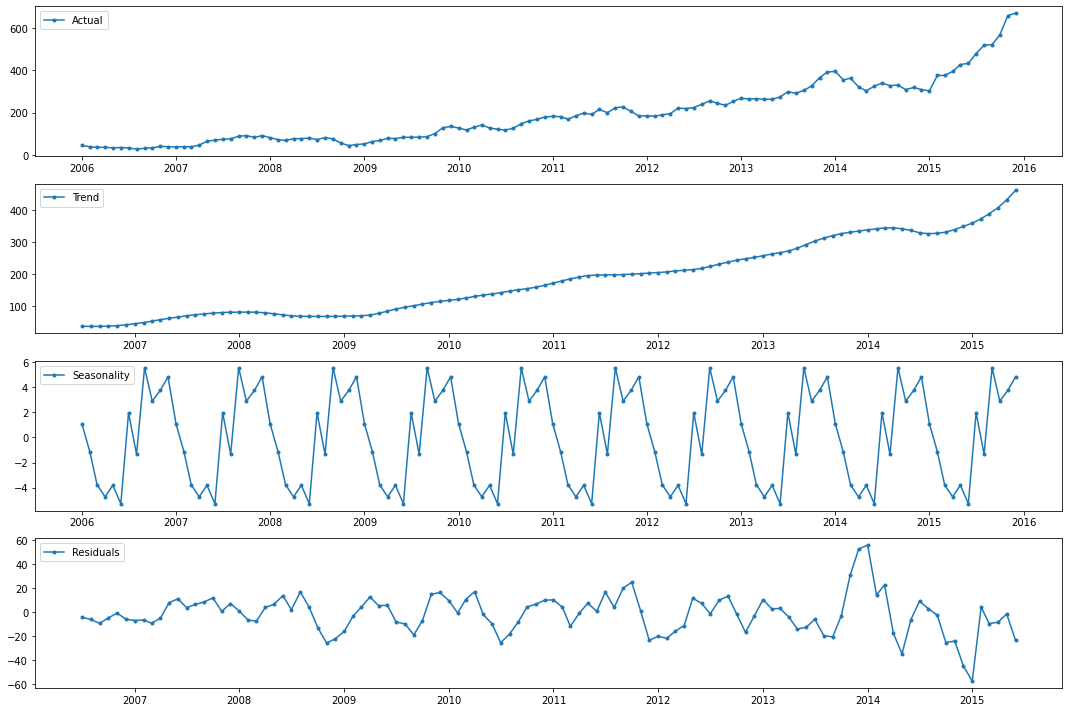

In [15]:
#Importing the seasonal_decompose function to decompose the time series
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(df_train)

trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

plt.figure(figsize=(15,10))
plt.subplot(411)
plt.plot(df_train, label='Actual', marker='.')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', marker='.')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', marker='.')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', marker='.')
plt.legend(loc='upper left')
plt.tight_layout()

**Observations:**
- We can see that there are significant **trend, seasonality and residuals components** in the series
- The plot for seasonality shows that **Amazon's stock prices spike in July, September, and December.**

**Now let's move on to the model building section. First, we will plot the `ACF` and `PACF` plots to get the values of p and q i.e. order of AR and MA models to be used.**

### Plotting the auto-correlation function and partial auto-correlation function to get p and q values for AR, MA, ARMA, and ARIMA models

<Figure size 1152x576 with 0 Axes>

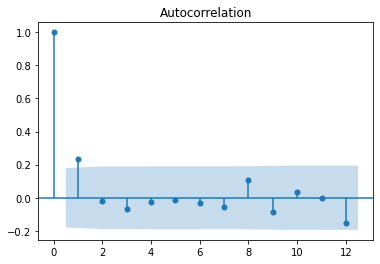

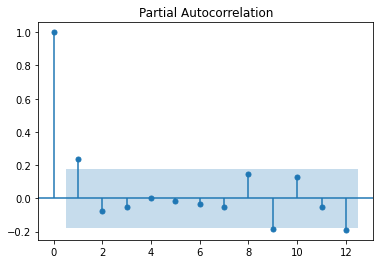

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plt.figure(figsize = (16,8))
plot_acf(df_shift, lags = 12) 
plt.show() 
plot_pacf(df_shift, lags = 12) 
plt.show()

**Observations:**
- From the above PACF plot we can see that **the highest lag** at which the plot extends beyond the statistically significant boundary is **lag 1.** 
- This indicates that an **AR Model of lag 1 (p=1)** should be sufficient to fit the data.
- Similarly, from the ACF plot, we can infer that **q=1.**

### AR Model

### **Question 3: Fit and predict the shifted series with the AR Model and calculate the RMSE. Also, visualize the time series and write your observations. (5 Marks)**

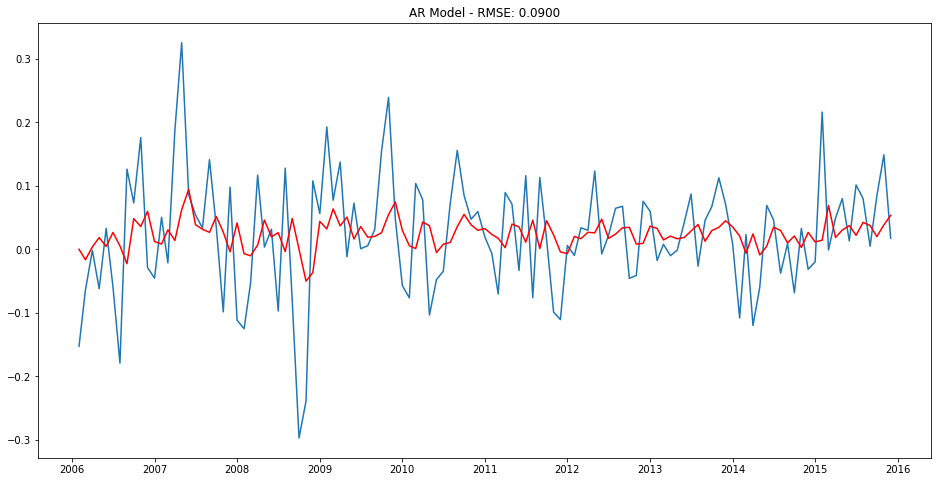

In [17]:
#Importing AutoReg function to apply AR model
from statsmodels.tsa.ar_model import AutoReg

plt.figure(figsize=(16,8))
model_AR = AutoReg(df_shift, lags=1) #Use number of lags as 1 and apply AutoReg function on df_shift series
results_AR = model_AR.fit() #fit the model
plt.plot(df_shift)
predict = results_AR.predict(start=0,end=len(df_shift)-1) #predict the series 
predict = predict.fillna(0) #Converting NaN values to 0
plt.plot(predict, color='red')
plt.title('AR Model - RMSE: %.4f'% mean_squared_error(predict,df_shift['close'], squared=False))  #Calculating rmse
plt.show()

**Observations:**
- The model does capture the general movement of our shifted stationary time series.
- This model is trying to fit the stationary time series with an autoregression of previous values with a lag of 1 plus white noise, we determined this in the previous steps.
    - If this model doesn't have the best fit, we can evaluate other models which base themselves on white noise or other properties.
- The RMSE is quite small, but we are also working with very small numbers.
- Even if RMSE is low, we have to check AIC as to see if it is overfitting, underfitting or not.
- We will need to analyze the RMSE and AIC value of all of our models so we can make the model selection. 
- While RMSE is important because it tells us the Root Mean Squared Error, AIC will also need to be considered as it is a great tool for model selection and knowing the goodness of the fit.

**Let's check the AIC value** of the model

In [18]:
results_AR.aic

-4.781419615400342

Now, let's build MA, ARMA, and ARIMA models as well, and see if we can get a better model 

### MA Model

**We will be using an ARIMA model with p=0 and d=0 so that it will work as an MA model**

### **Question 4: Fit and predict the shifted series with the MA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

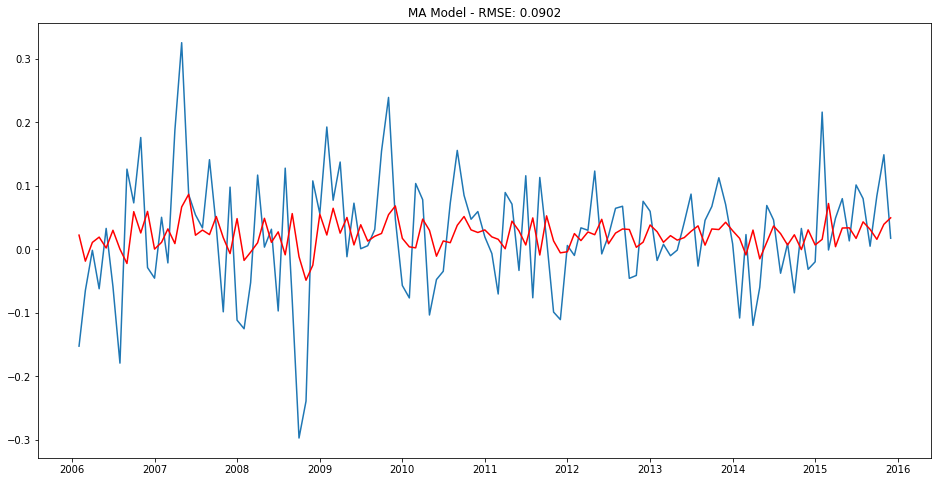

In [19]:
from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize=(16,8))
model_MA = ARIMA(df_shift, order=(0,0,1)) #Using p=0, d=0, q=1 and apply ARIMA function on df_shift series
results_MA = model_MA.fit() #fit the model
plt.plot(df_shift)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('MA Model - RMSE: %.4f'% mean_squared_error(results_MA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**
- The RMSE for this model is 0.002 higher than the AR model.
- Because of the way they are mathematically defined, the 2 models should behave quite differently, as moving average is a regression based on past white noise while AR is based on past x(t) values. We are using 2 models which consider different areas of the time series.
- We need to check the AIC, the values could be different. Since the RMSE is almost equal, we need to evaluate which model has a lower AIC value to make the selection. The lower one will fit the training data better.

Let's check the AIC value of the model

In [20]:
results_MA.aic

-229.0949393095408

- **The MA model is giving a much lower AIC** when compared to the AR model, implying that **the MA model fits the training data better.** 

### ARMA Model

We will be using an **ARIMA model with p=1 and q=1** (as observed from the ACF and PACF plots) **and d=0 so that it will work as an ARMA model.**

### **Question 5: Fit and predict the shifted series with the ARMA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

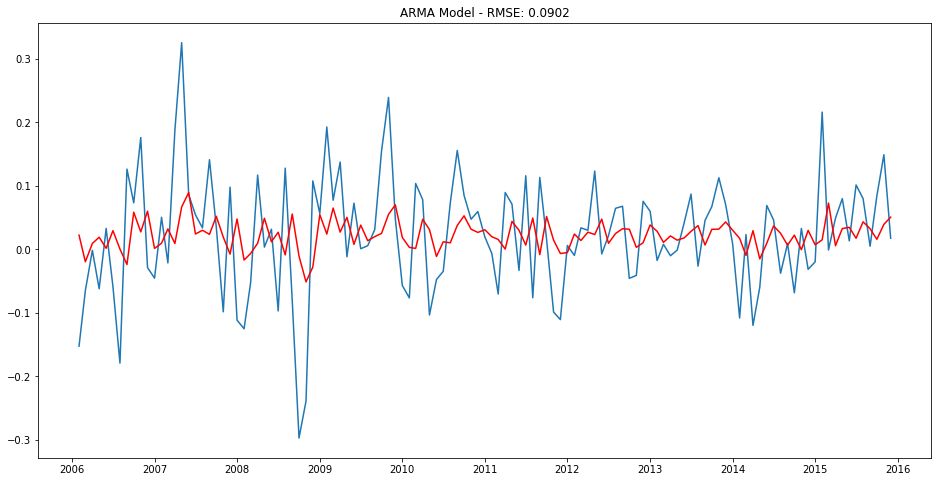

In [21]:
plt.figure(figsize=(16,8))
model_ARMA = ARIMA(df_shift, order=(1,0,1)) #Using p=1, d=0, q=1 and apply ARIMA function on df_shift series
results_ARMA = model_ARMA.fit() #fit the model
plt.plot(df_shift)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('ARMA Model - RMSE: %.4f'% mean_squared_error(results_ARMA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**
- As we saw, MA model fits the training data much better than AR. Despite having similar RMSE, it's AIC is much lower.
- Since we are working with a time series, if we follow linear systems theory and linearity then we can make a linear combination of both AR and MA methods for a new model. 
    - Let's try this out with ARMA (Auto Regressive Moving Average) which adds up both of this models.
        - That way we can evaluate if it is better than either model individually.
- The RMSE is once again very similar between al 3 models. We will have to evaluate the AIC to see if is a better model than either of the previous options.

**Let's check the AIC value** of the model

In [22]:
results_ARMA.aic

-227.11129236959948

- **The AIC value of the ARMA model is more or less similar** to MA model 

**Let us try using the ARIMA Model.**

### ARIMA Model

We will be using an **ARIMA Model with p=1, d=1, & q=1**.

### **Question 6: Fit and predict the shifted series with the ARIMA Model and calculate the RMSE. Also, visualize the time series and write your observations. (2 Marks)**

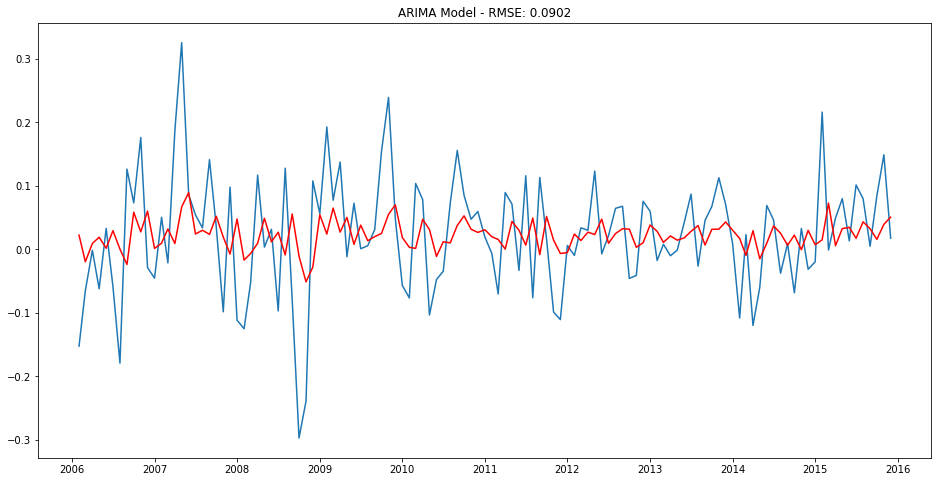

In [23]:
from statsmodels.tsa.arima_model import ARIMA

plt.figure(figsize=(16,8))
model_ARIMA = ARIMA(df_log, order=(1,1,1)) #Using p=1, d=1, q=1 and apply ARIMA function on df_log series
results_ARIMA = model_ARIMA.fit() #fit the model
plt.plot(df_shift)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA Model - RMSE: %.4f'% mean_squared_error(results_ARIMA.fittedvalues,df_shift['close'], squared=False))
plt.show()

**Observations:**
- In the beginning, both our original data frame and our log data frame were not stationary. We made them this way with the shifting. ARIMA model is a combination of AR and MA as well, but it works with not stationary data frames by converting them into stationary via differencing a certain number of times.
- Lets see how well an ARIMA model based on df_log data works if we difference it one time and keep our AR and MA terms as 1.
- The RMSE is once again the same.
- We need to evaluate the AIC again to do model evaluation and see which one could be best.
- The ARIMA model converts the df_log into a stationary time series. We already did this process previously, to give the series stationarity in df_shift. It could be possible that ARIMA has very similar performance to the ARMA model we used before.

**Let's check the AIC value** of the model

In [24]:
results_ARIMA.aic

-227.11129236959948

- **The AIC value of the ARIMA model is the same** as the ARMA model. 

We can see that **all the models return almost the same RMSE.** There is not much difference in AIC value as well across all the models except for the AR model.

**We can choose to predict the values using ARIMA as it takes into account more factors than AR, MA, ARMA models.**

In [25]:
# Printing the fitted values
predictions=pd.Series(results_ARIMA.fittedvalues)
predictions

date
2006-02-01    0.022235
2006-03-01   -0.019667
2006-04-01    0.009184
2006-05-01    0.018985
2006-06-01    0.001615
                ...   
2015-08-01    0.043234
2015-09-01    0.032286
2015-10-01    0.015696
2015-11-01    0.039276
2015-12-01    0.050567
Length: 119, dtype: float64

### Inverse Transformation

Now we have fitted values using the ARIMA model, **we will use the inverse transformation to get back the original values.**

### **Question 7: Apply an inverse transformation on the predictions of the ARIMA Model. (5 Marks)**

In [26]:
#First step - doing cumulative sum
predictions_cumsum = predictions.cumsum() # use .cumsum fuction on the predictions
predictions_cumsum

date
2006-02-01    0.022235
2006-03-01    0.002568
2006-04-01    0.011753
2006-05-01    0.030738
2006-06-01    0.032353
                ...   
2015-08-01    2.526098
2015-09-01    2.558385
2015-10-01    2.574081
2015-11-01    2.613357
2015-12-01    2.663924
Length: 119, dtype: float64

In [27]:
#Second step - Adding the first value of the log series to the cumulative sum values
predictions_log = pd.Series(df_log['close'].iloc[0], index=df_log.index)
predictions_log = predictions_log.add(predictions_cumsum, fill_value=0)
predictions_log

date
2006-01-01    3.811539
2006-02-01    3.833774
2006-03-01    3.814108
2006-04-01    3.823292
2006-05-01    3.842277
                ...   
2015-08-01    6.337638
2015-09-01    6.369924
2015-10-01    6.385620
2015-11-01    6.424896
2015-12-01    6.475464
Length: 120, dtype: float64

In [28]:
#Third step - applying exponential transformation
predictions_ARIMA = np.exp(predictions_log) #use exponential function
predictions_ARIMA

date
2006-01-01     45.220000
2006-02-01     46.236724
2006-03-01     45.336291
2006-04-01     45.754599
2006-05-01     46.631544
                 ...    
2015-08-01    565.459034
2015-09-01    584.013535
2015-10-01    593.252425
2015-11-01    617.016925
2015-12-01    649.020093
Length: 120, dtype: float64

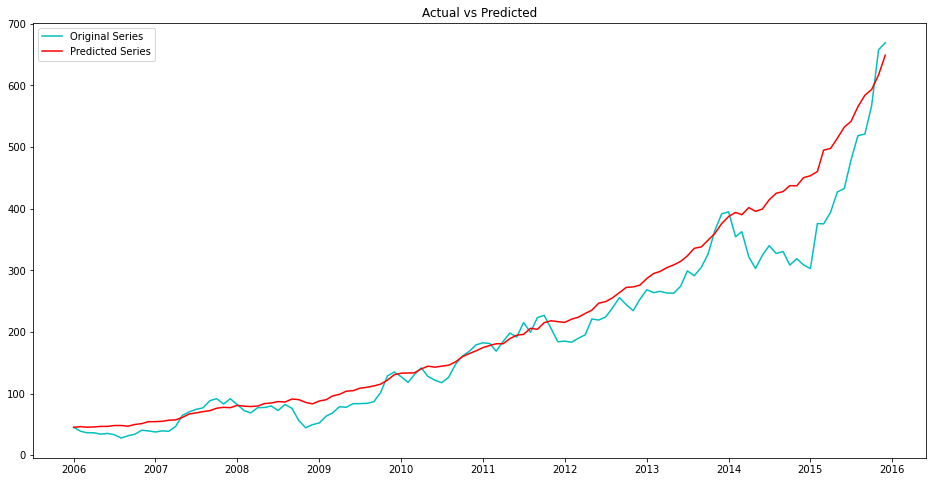

In [29]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df_train, color = 'c', label = 'Original Series')  #plot the original train series
plt.plot(predictions_ARIMA, color = 'r', label = 'Predicted Series')  #plot the predictions_ARIMA 
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- We can see that **the predicted series is very similar to the original series** i.e. The model is good at predicting values on the training data except for the dip in stock prices in 2015 which may have been due to some external factors that are not included in this model. 
- Let us **forecast the closing prices for the next 24 months.**

### Forecasting the values for next 24 months and compare it with test data

**To forecast the values for the next 24 months using the ARIMA model, we need to follow the steps below:**
1. Forecast the log-transformed fitted values for the next 24 months
2. Make a list of these 24 month (2016-2017) forecasted values
3. Convert that list into a series so that we can work with pandas functions 
4. Make a dataframe where we have the dates starting from 2016-01-01 to 2017-12-01 as the index and the respective forecasted values
5. Apply the inverse transformation and get the real forecasted values

### **Question 8: Forecast the stocks prices for the next 24 months and perform the inverse transformation. (5 Marks)**

In [30]:
#Forecasting the values for next 24 months
forecasted_ARIMA = results_ARIMA.forecast(steps=24) #forecast using the results_ARIMA for next 24 months. Keep steps=24
forecasted_ARIMA[0]

array([6.52115937, 6.54310817, 6.56533179, 6.58756626, 6.60980115,
       6.63203606, 6.65427097, 6.67650588, 6.69874079, 6.7209757 ,
       6.74321062, 6.76544553, 6.78768044, 6.80991535, 6.83215026,
       6.85438517, 6.87662008, 6.89885499, 6.92108991, 6.94332482,
       6.96555973, 6.98779464, 7.01002955, 7.03226446])

In [31]:
# Creating a list containing all the forecasted values
list1 = forecasted_ARIMA[0].tolist()
series1 = pd.Series(list1)
series1

0     6.521159
1     6.543108
2     6.565332
3     6.587566
4     6.609801
5     6.632036
6     6.654271
7     6.676506
8     6.698741
9     6.720976
10    6.743211
11    6.765446
12    6.787680
13    6.809915
14    6.832150
15    6.854385
16    6.876620
17    6.898855
18    6.921090
19    6.943325
20    6.965560
21    6.987795
22    7.010030
23    7.032264
dtype: float64

In [32]:
#Making a new dataframe to get the additional dates from 2016-2018
index = pd.date_range('2016-01-1','2018-1-1' , freq='1M')- pd.offsets.MonthBegin(1)
df1 = pd.DataFrame()
df1['forecasted'] = series1
df1.index = index
df1

,forecasted
2016-01-01,6.521159
2016-02-01,6.543108
2016-03-01,6.565332
2016-04-01,6.587566
2016-05-01,6.609801
2016-06-01,6.632036
2016-07-01,6.654271
2016-08-01,6.676506
2016-09-01,6.698741
2016-10-01,6.720976


In [33]:
#Applying exponential transformation to the forecasted log values
forecasted_ARIMA = np.exp(df1["forecasted"]) #use exponential function on forecasted data
forecasted_ARIMA

2016-01-01     679.365566
2016-02-01     694.441672
2016-03-01     710.047444
2016-04-01     726.011791
2016-05-01     742.335390
2016-06-01     759.026021
2016-07-01     776.091923
2016-08-01     793.541535
2016-09-01     811.383482
2016-10-01     829.626587
2016-11-01     848.279869
2016-12-01     867.352551
2017-01-01     886.854062
2017-02-01     906.794043
2017-03-01     927.182355
2017-04-01     948.029076
2017-05-01     969.344513
2017-06-01     991.139206
2017-07-01    1013.423930
2017-08-01    1036.209702
2017-09-01    1059.507788
2017-10-01    1083.329708
2017-11-01    1107.687238
2017-12-01    1132.592421
Name: forecasted, dtype: float64

Now, let's try to visualize the original data with the predicted values on the training data and the forecasted values.

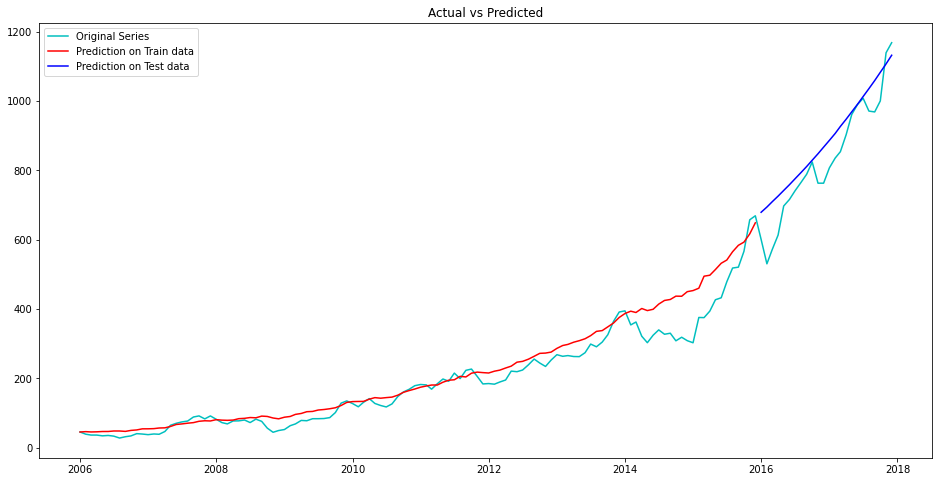

In [34]:
#Plotting the original vs predicted series
plt.figure(figsize=(16,8))
plt.plot(df, color = 'c', label = 'Original Series')
plt.plot(predictions_ARIMA, color = 'r', label = 'Prediction on Train data') #plot the predictions_ARIMA series
plt.plot(forecasted_ARIMA, label = 'Prediction on Test data', color='b')  #plot the forecasted_ARIMA series
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

**Observations:**
- **As observed earlier, most of the predicted values on the training data are very close to the actual values** except for the dip in stock prices in the year 2015.
- **On the test data, the model is able to correctly predict the trend of the stock prices**, as we can see that the blue line appears to be close to the actual values (cyan blue) and they both have an upward trend. **However the test predictions are not able to identify the volatile variations in the stock prices over the last 2 years.**

Let's test the RMSE of the transformed predictions and the original value on the training and testing data to check whether the model is giving a generalized performance or not.

### **Question 9: Check the RMSE on the original train and test data and write your conclusion from the above analysis. (4 Marks)**

In [35]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(predictions_ARIMA,df_train, squared=False) #calculate RMSE using the predictions_ARIMA and df_train 
error

43.27243226946914

In [36]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(forecasted_ARIMA,df_test, squared=False)  #calculate RMSE using the forecasted_ARIMA and df_test
error

73.39354763458931

### Conclusion

- The first step we did, was to check stationarity of our amazon stock time series. To do this, we used Augmented Dickey-Fuller (ADF) Test, where our null hypothesis was non-stationarity. 
    - The original time series was not stationary, so we had to make it stationary to be able to test models like AR. MA and ARMA which work with stationary series.
    - We applied a log transformation to remove exponential variance. This made the standard deviation constant, but it was not stationary yet. While we could have applied ARIMA model to this data, we still want to make it stationary as to test other, different models and be able to make a process of best fitting model prediction via AIC and RMSE.
    - After this, we shifted the log transformed data. After performing the ADF Test again, we could confirm that this new series is stationary. Thus, we can apply AR, MA and ARMA models to it.
- While all 4 models had very similar RMSE, AR had the highest (approximately -4) AIC. AIC is a great tool to evaluate model fitting the data properly (and we can see the best generalizing and precise model via checking both AIC and RMSE). The other 3 models had similar AIC (between -227 and -229). 
    - Since they were all performing similarly in these tests, we decided to keep ARIMA as it takes into account more factors than the other options.
- After applying the inverse transformation to our predictions, we could see that ARIMA made a great fit to the training data and predicted very well. It did not predict the volatile dips properly though, as those could be attributed to external factors that a mathematical model such as ARIMA does not take into account. But the general upwards trend of amazon stocks was taken into account.
- The forecasting for the next 24 months also fit the test data properly. Our model has a very good fit, which we chose thanks to the AIC values. It is performing greatly in both training and test data.
    - The RMSE in both is low considering the values we are dealing with. While significantly lower on the training set, it is still very low on the test set and we can conclude that the model has a very good fit.
- After analyzing our forecasts, we can conclude that:
    - Amazon stock prices are increasing exponentially.
    - This model could be used to know general growth trends for medium-long term investments. While it might not capture dips and spikes caused by volatility, it can tell you that the stock price will tend to grow. You could use these kind of models to invest on a stock which is expected to growth in the long term.
    - Our model does not take into account volatile dips or spikes, and despite dips like the one in 2015, it still had good predictive power.
        - This means that amazon stock prices tend to grow in the long term, despite dips in the short-short medium term.
        - A good model will forecast amazon stock to keep growing. And as seen before in real data, the dips did not stop this long term growth.
    - Amazon stock prices are a great investment for anyone. Both the normal time series and the predictive models agree that the price has a positive trend, despite volatilty.